In [1]:
import sys
from pathlib import Path
import numpy as np
from scipy.special import factorial as sp_factorial

from matplotlib import pyplot as plt
from ipywidgets import interact
import itertools

# set path to project directory
root_dir = Path.cwd().parent
if not root_dir in sys.path:
    sys.path.insert(0, str(root_dir))

from placefield_dynamics.neuron_matching.utils import loadmat, load_data
from placefield_dynamics.placefield_detection.utils import gauss_smooth, get_firingrate

# %matplotlib widget

2025-04-14 09:58:34.510877: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 09:58:34.600712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/wollex/Documents/Science/WolfGroup/PlaceFields/Programs/PC_analysis/placefield_dynamics/placefield_detection


In [2]:
folderPath = Path("../../data/Subhodeep/ID20/20230913/")
stimulusPath = folderPath / "ID20_1_230913.1_ipsi_stimProtocol_191"
caimanPath = folderPath / "results_CaImAn_20230913_20_00001_align.mat"

"""
	20&40?45? is decent, other mice have longer stimulation!
	try ones with 500ms stimulation
    
    -> ID 37 & 81 (wt, should have good responses)
"""

ld = loadmat(stimulusPath)
data = ld["runInfo"]

caiman_data = load_data(caimanPath)

data["frame_times"] = np.arange(caiman_data["C"].shape[1]) / 30.05
arrays = {
    "angles": data["angle"],
    "cycles": data["CPD"],
    "phases": np.unique(data["stim_phases"]),
}

steps = {
    "angles": len(arrays["angles"]),
    "cycles": len(arrays["cycles"]),
    "phases": len(arrays["phases"]),
}

n_cells = caiman_data["C"].shape[0]
firing_maps, dwelltime = [
    np.zeros(
        (
            steps["phases"],
            steps["angles"],
            steps["cycles"],
            n_cells,
        )
    )
    for _ in range(2)
]

dStimulus = 0.1  # time to wait after stimulus onset before starting to count spikes
spikes = np.zeros((n_cells, len(data["frame_times"])))
for n in range(n_cells):
    # thr = np.percentile(caiman_data["S"][n, caiman_data["S"][n, :] > 0], 50)
    # spikes[n, :] = caiman_data["S"][n, :] / np.floor(thr)
    _, _, spikes[n, :] = get_firingrate(
        caiman_data["S"][n, :], f=30.05, sd_r=1, Ns_thr=10
    )

for prod in itertools.product(
    enumerate(arrays["phases"]),
    enumerate(arrays["angles"]),
    enumerate(arrays["cycles"]),
):
    idx, elems = zip(*prod)

    idxes = (
        (data["stim_phases"] == elems[0])
        & (data["stim_angle"] == elems[1])
        & (data["stim_cycles"] == elems[2])
    ).flatten()

    times = data["stimulus_clock"][idxes, :]
    for t, time in enumerate(times):
        start_idx = np.argmin(np.abs(data["frame_times"] - (time[0] + dStimulus)))
        end_idx = np.argmin(np.abs(data["frame_times"] - time[1]))

        firing_maps[idx[0], idx[1], idx[2], :] += np.sum(
            # caiman_data["S"][:, start_idx:end_idx], axis=1
            spikes[:, start_idx:end_idx],
            axis=1,
        )  # / (data["frame_times"][end_idx] - data["frame_times"][start_idx])

        dwelltime[idx[0], idx[1], idx[2], :] += (
            data["frame_times"][end_idx] - data["frame_times"][start_idx]
        )

In [3]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
root_dir = Path.cwd().parent
sys.path.insert(0,str(root_dir))

from orientation_tuning.HierarchicalBayesInference import HierarchicalBayesInference

In [4]:
neuron = 15
# fmap = gauss_smooth(firing_maps[..., neuron], (0, 1, 1), mode="wrap")
fmap = firing_maps[..., neuron]
hbm = HierarchicalBayesInference(
    fmap,
    dwelltime[..., neuron],
    (arrays["phases"], arrays["angles"], arrays["cycles"]),
    [140, 114],
)
hbm.set_priors(wrap=["theta", "theta_gauss"])
sampler, results = hbm.run_sampling(show_status=True, n_live=400)

[140, 114]
get gratings
[[ True  True  True  True  True  True  True  True False False False]
 [False False False False False False False False  True  True  True]]


ValueError: need more than 1 value to unpack

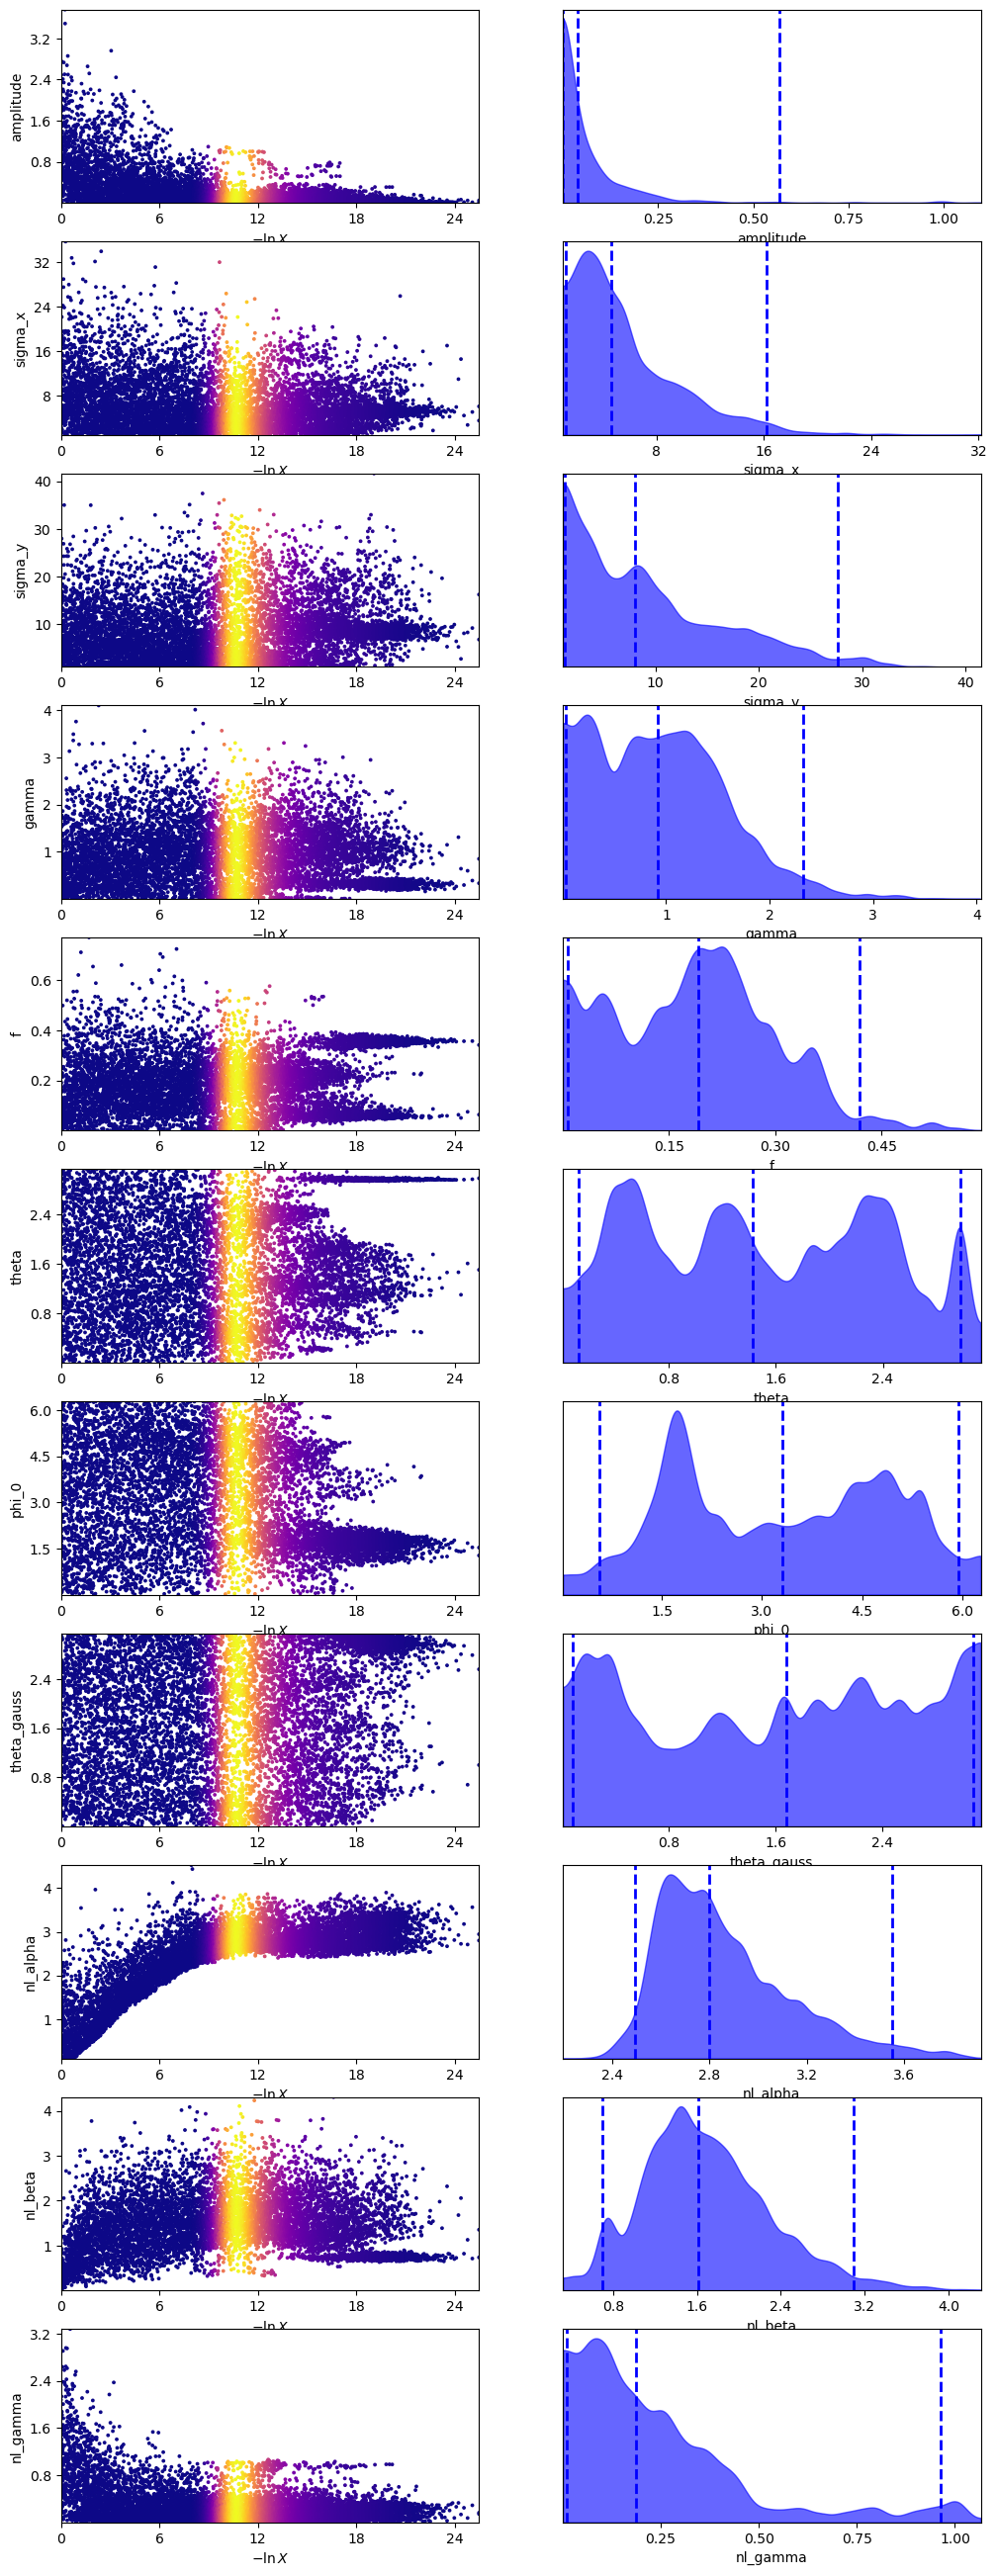

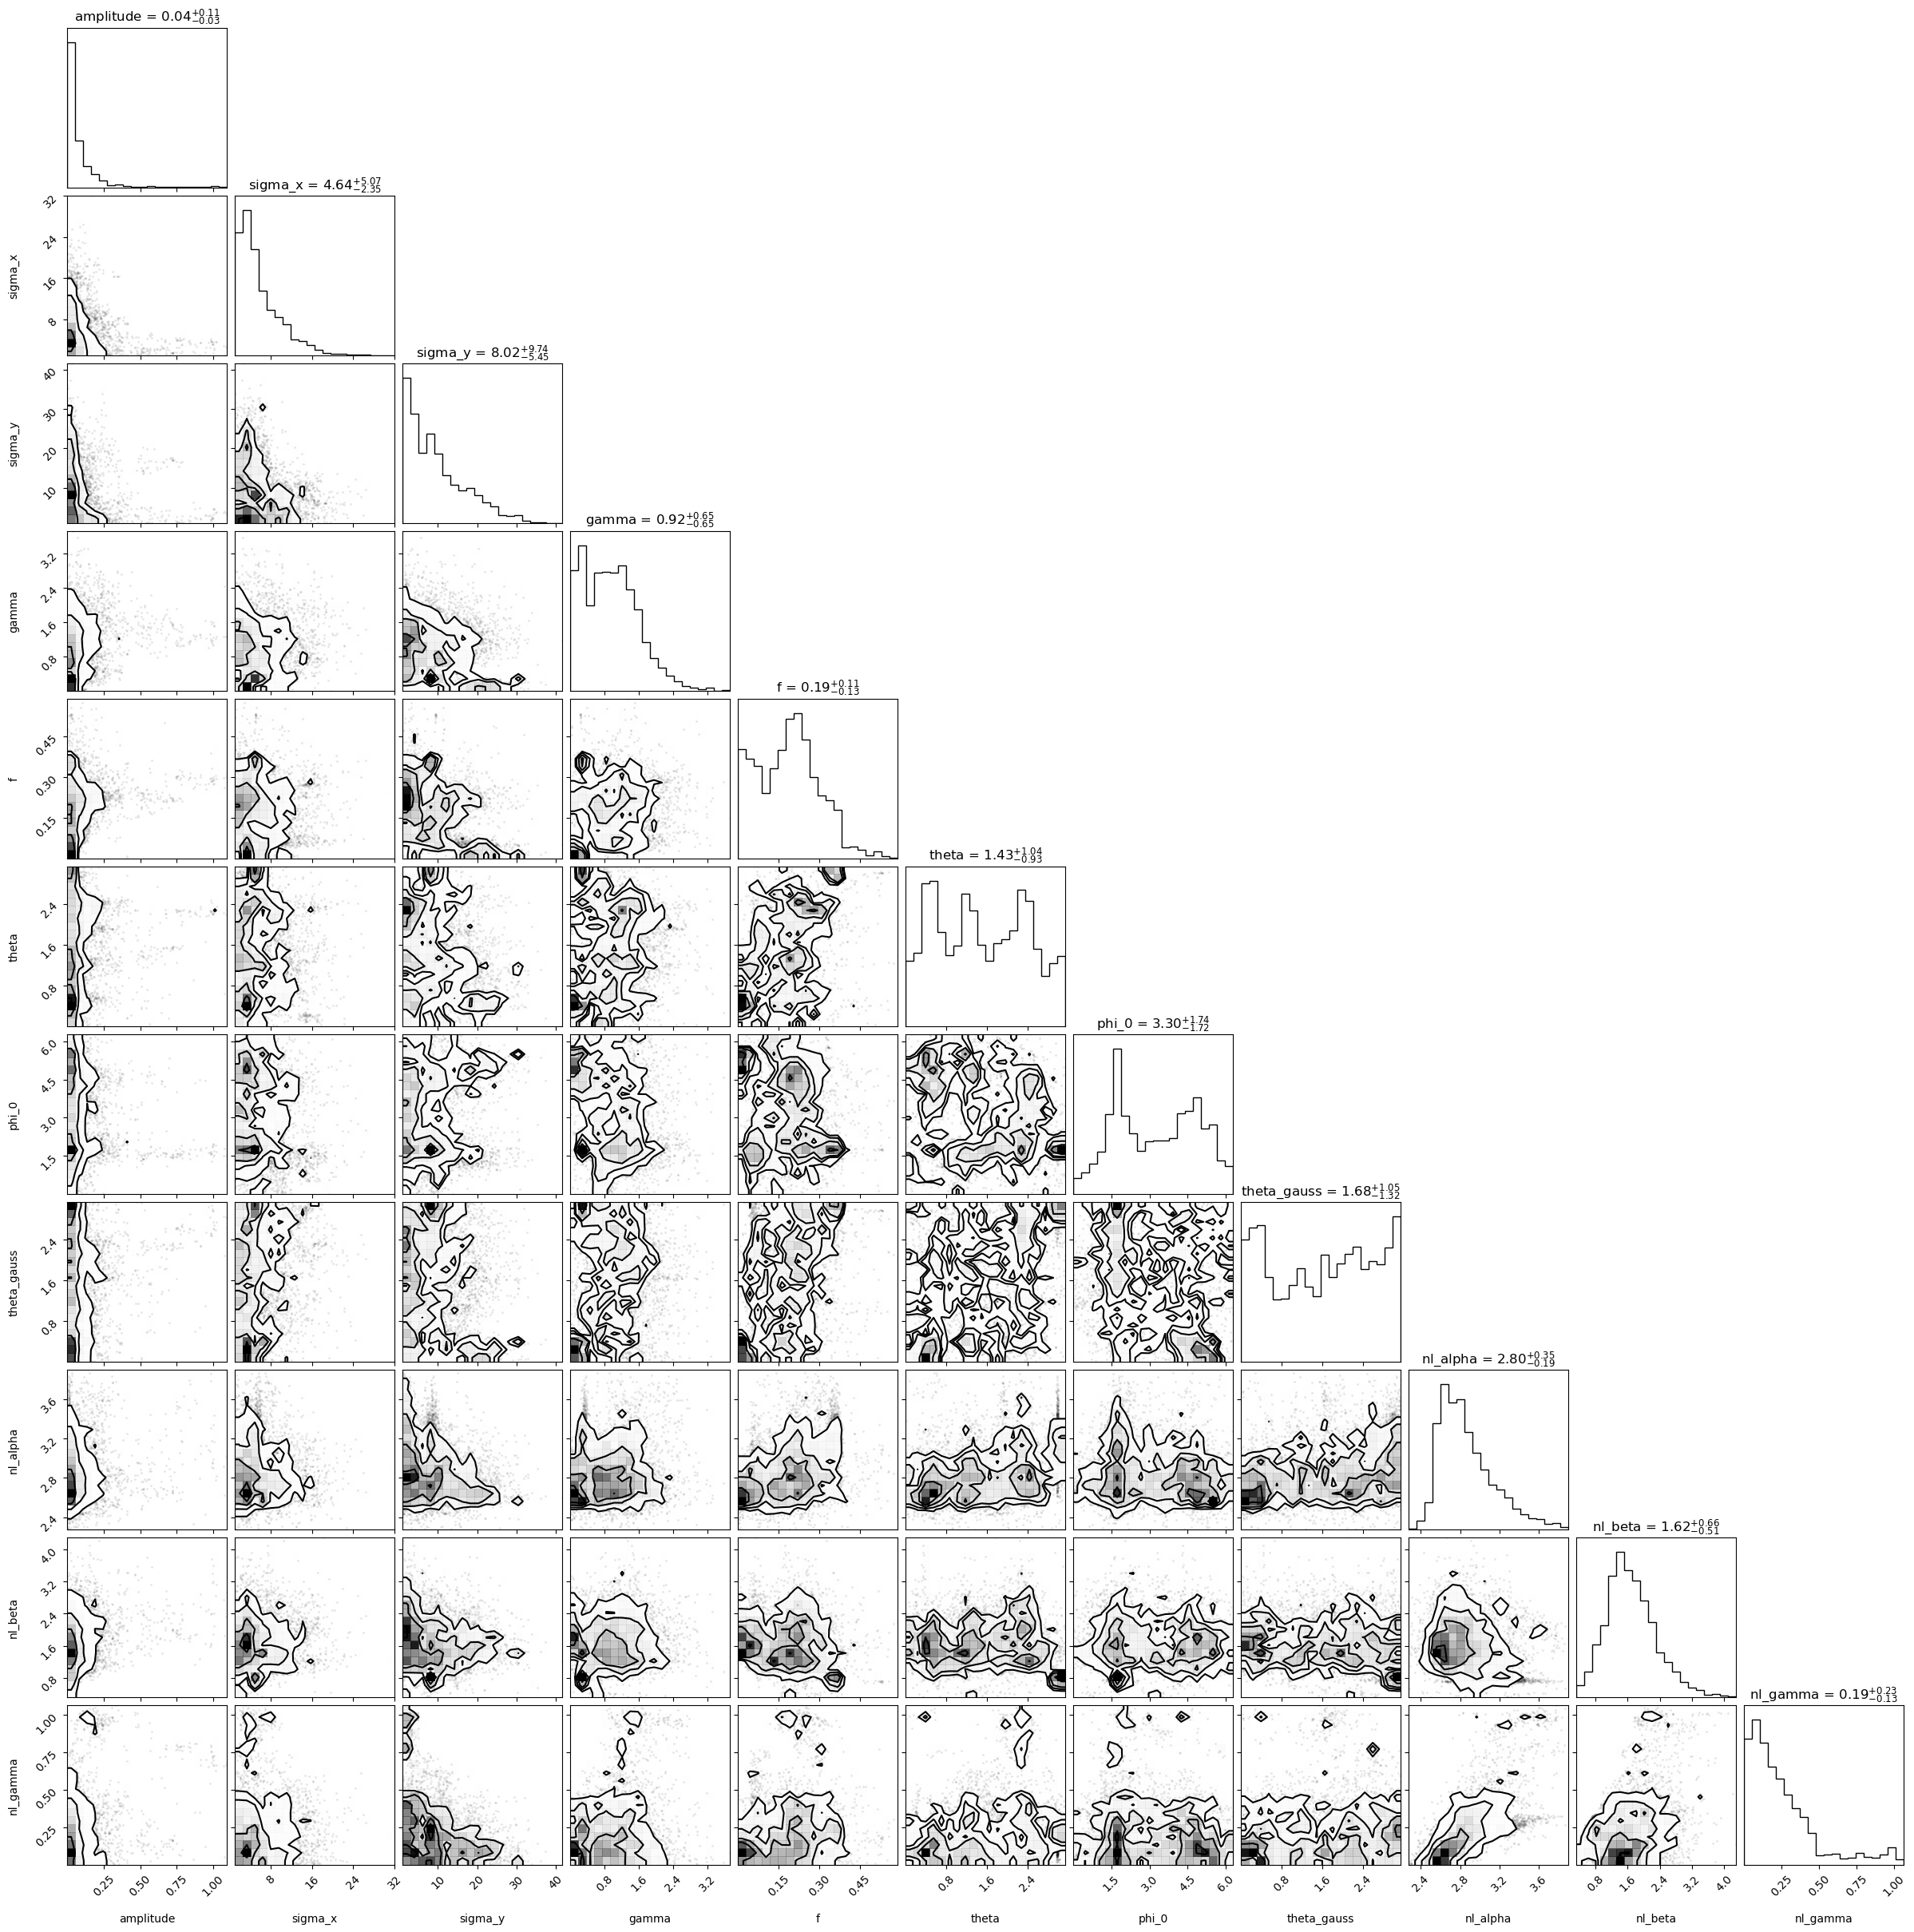

In [306]:
# from ultranest.plot import cornerplot, traceplot
sampler.plot_trace()
sampler.plot_corner()
# traceplot(results)
# cornerplot(sampler)
# traceplot(sampler)

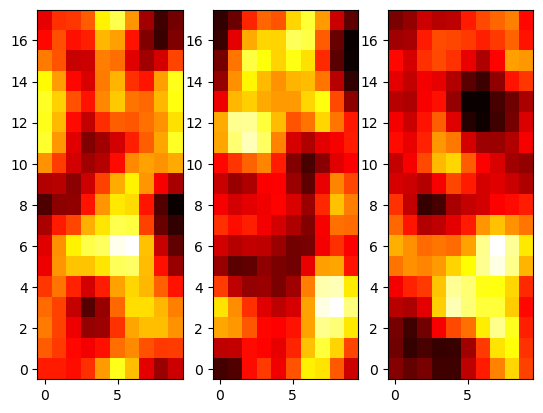

In [162]:
fig = plt.figure()

for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(
        gauss_smooth(fmap[i, ...], (1, 1)), cmap="hot", aspect="auto", origin="lower"
    )

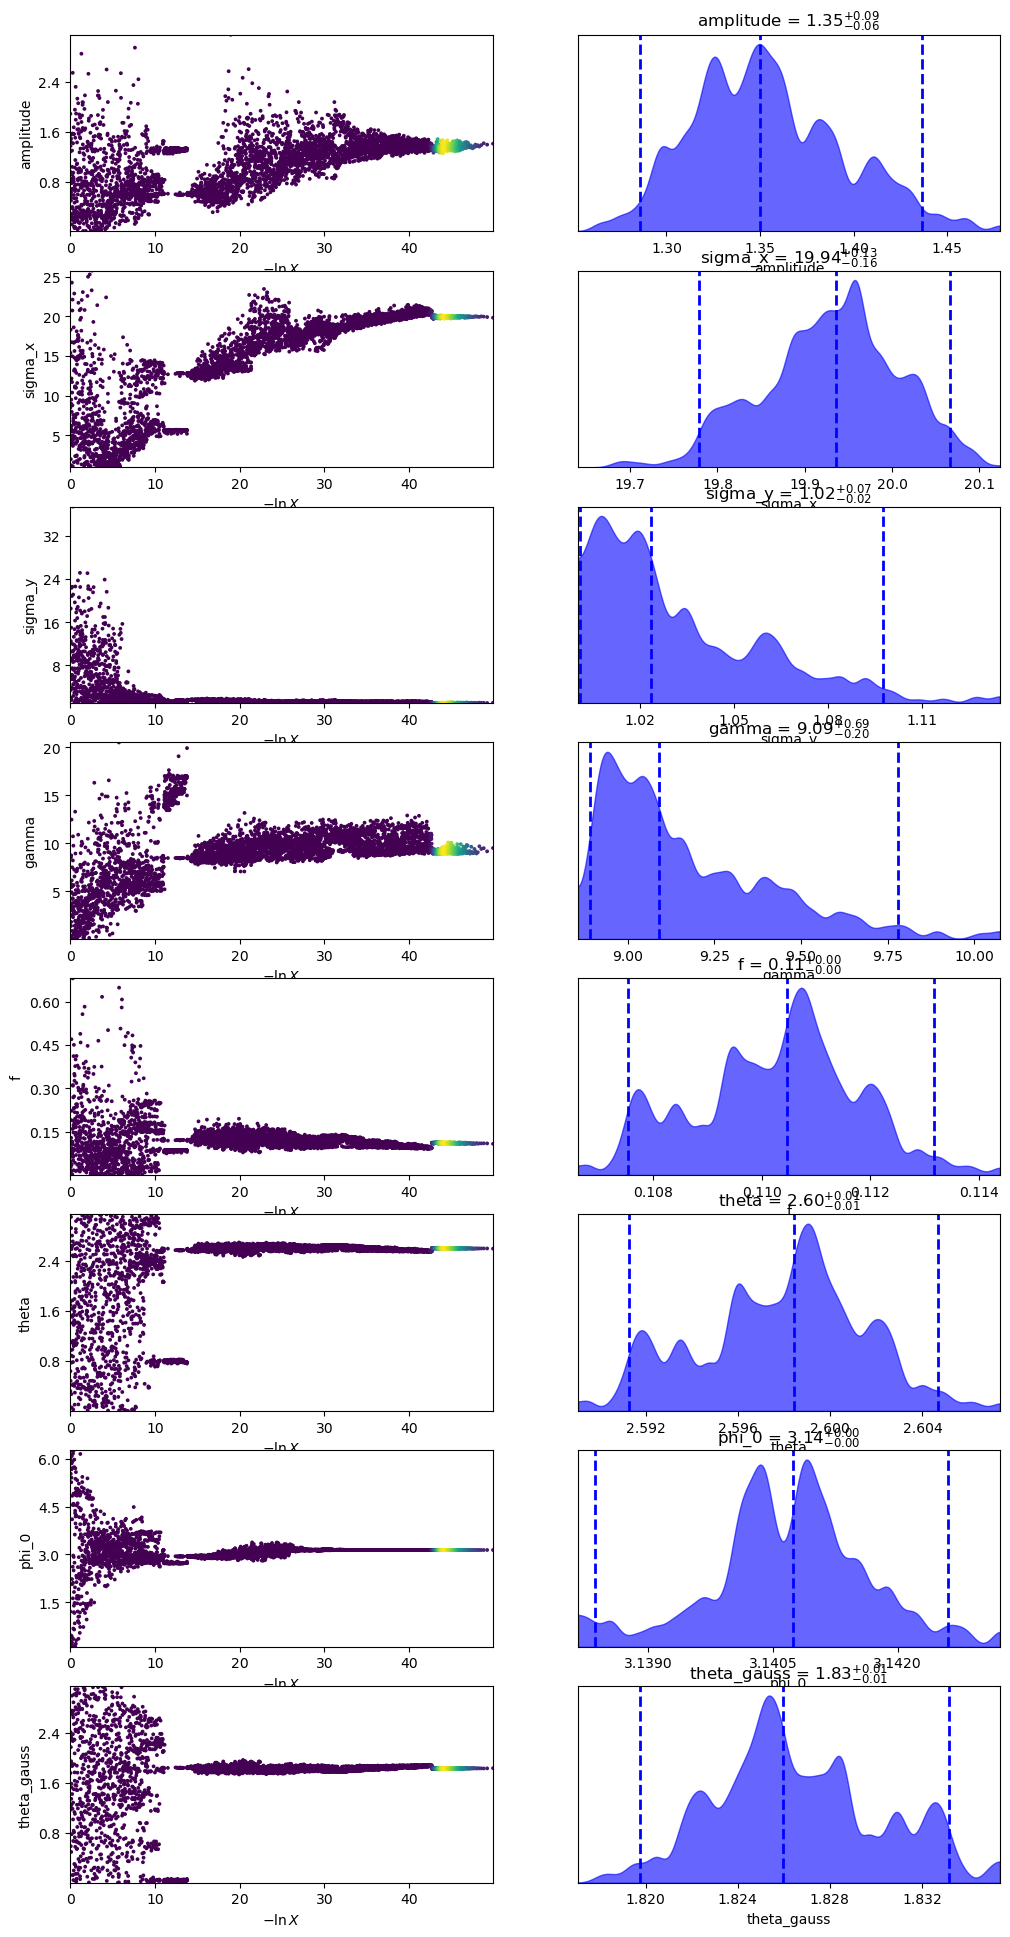

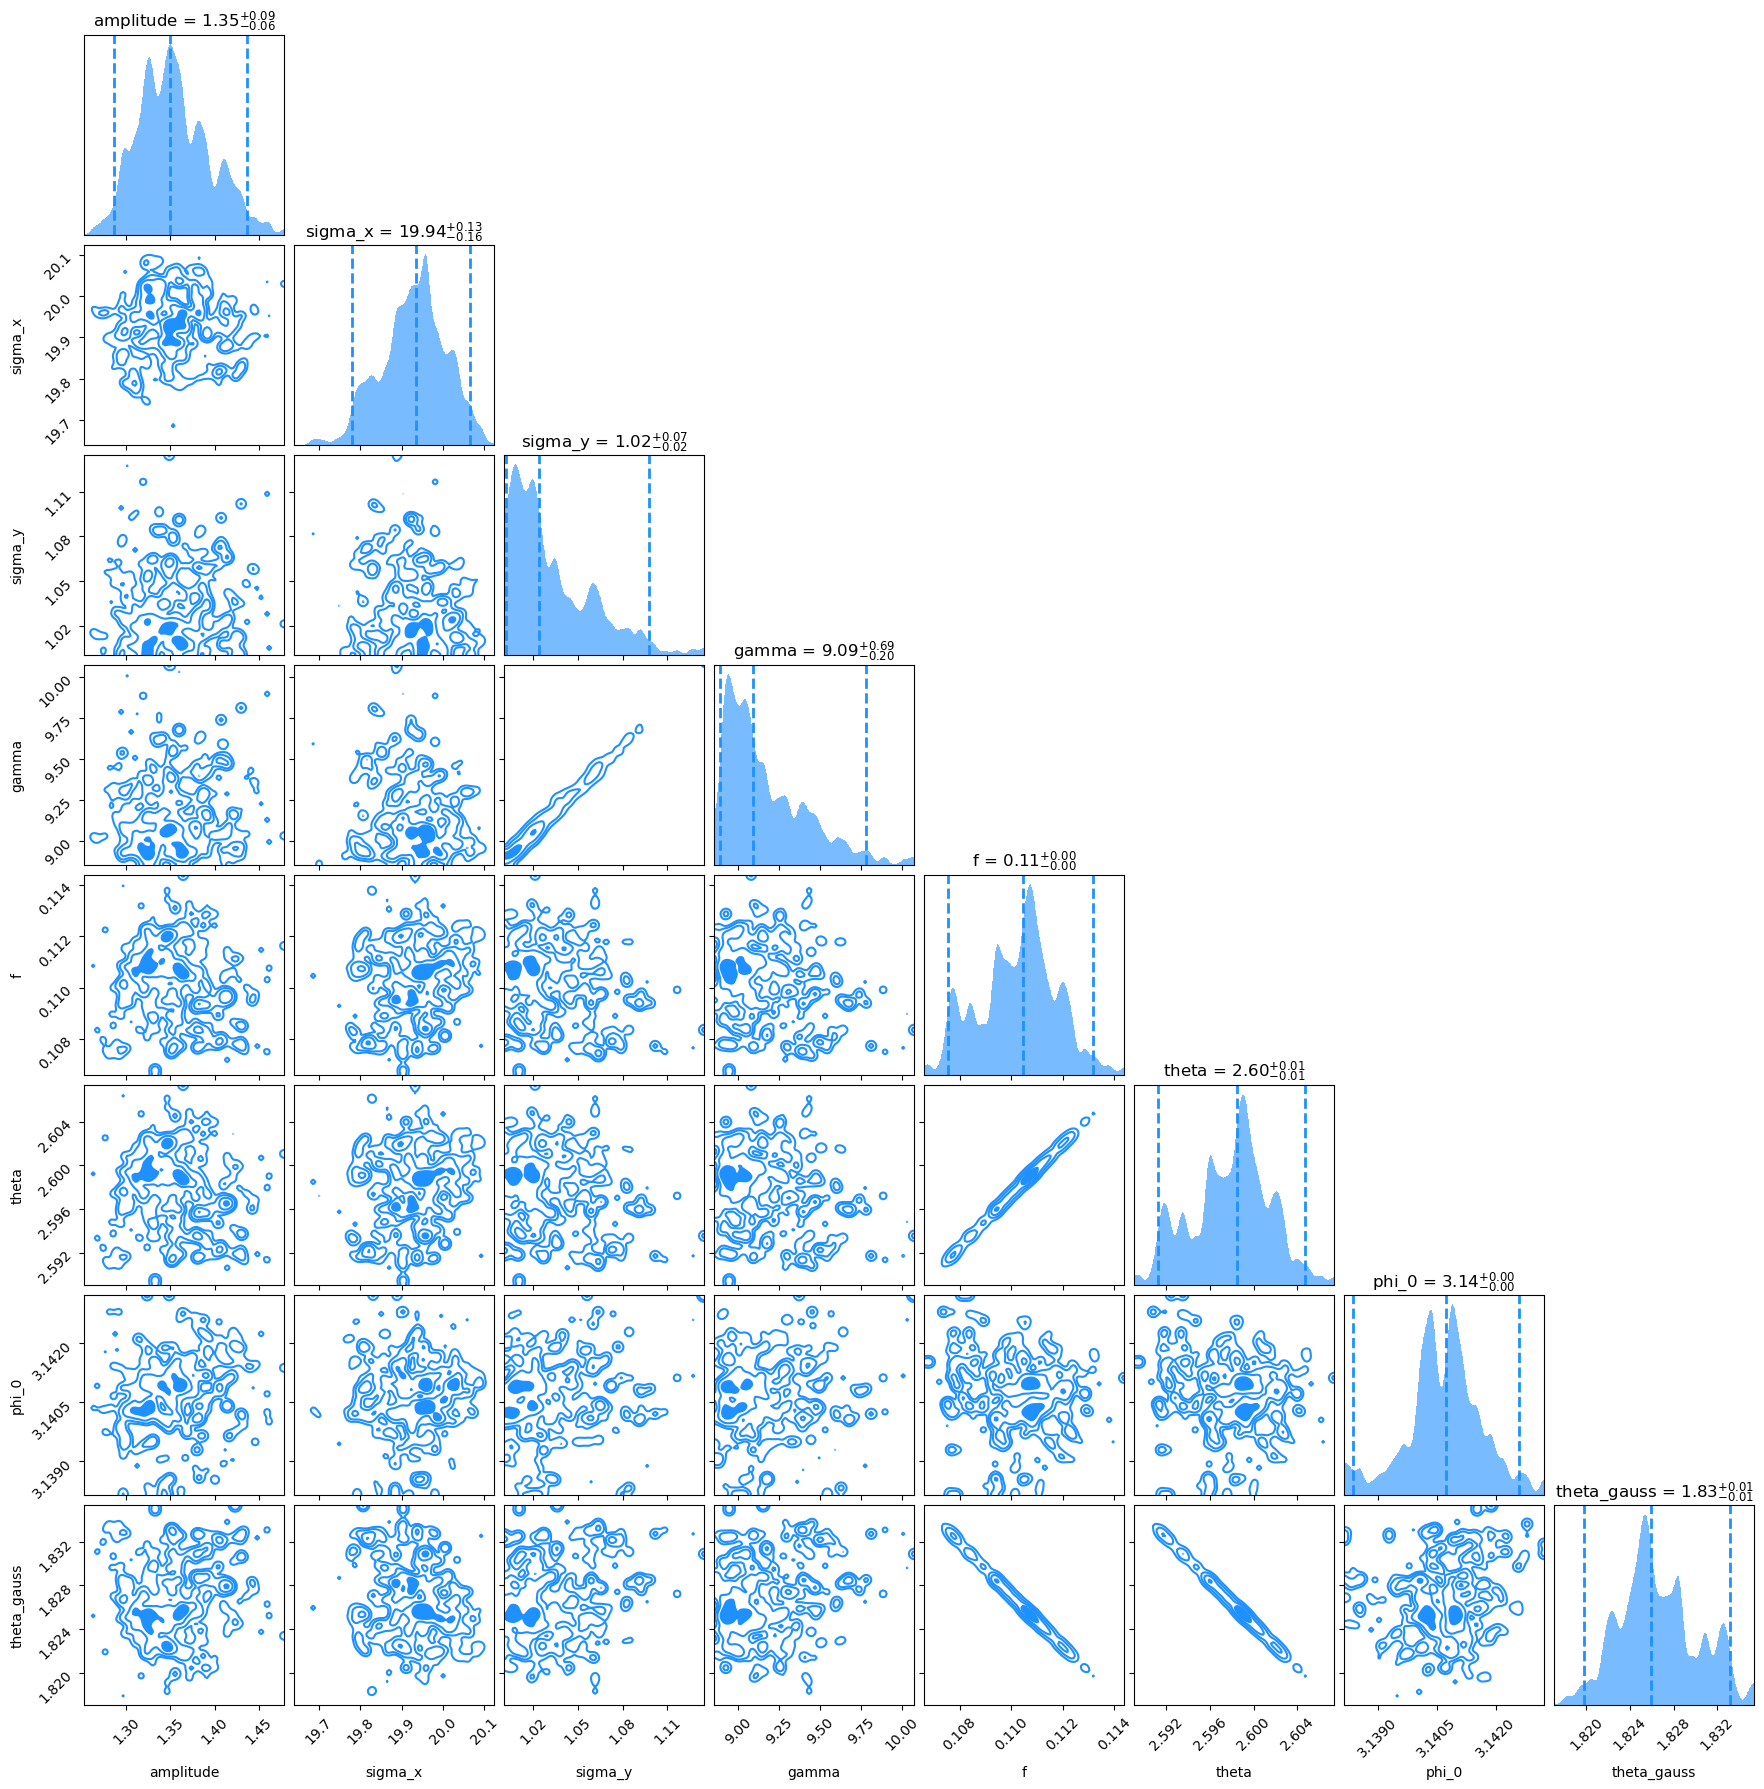

In [92]:
# %matplotlib widget
from dynesty import plotting as dyplot

dyplot.traceplot(
    sampler.results,
    show_titles=True,
    labels=hbm.paramNames,
    trace_cmap="viridis",
)
plt.show(block=False)

dyplot.cornerplot(
    sampler.results,
    show_titles=True,
    color="dodgerblue",
    labels=hbm.paramNames,
)
plt.show(block=False)

In [163]:
mean = {}
mode = "ultranest"
for i, key in enumerate(hbm.paramNames):
    if mode == "dynesty":
        samp = sampler.results.samples[:, i]
        weights = sampler.results.importance_weights()
    else:
        samp = results["weighted_samples"]["points"][:, i]
        weights = results["weighted_samples"]["weights"]
    mean[key] = (samp * weights).sum()
    print(f"{key} mean: {mean[key]}")

amplitude mean: 0.08309734346744291
sigma_x mean: 5.6144058826340135
sigma_y mean: 10.853751544845021
gamma mean: 0.6961662452912125
f mean: 0.17465228425680063
theta mean: 1.5247908710405915
phi_0 mean: 2.440717093165703
theta_gauss mean: 1.2528805823975935
nl_alpha mean: 2.579215279085485


-2.057326987434213
0.0


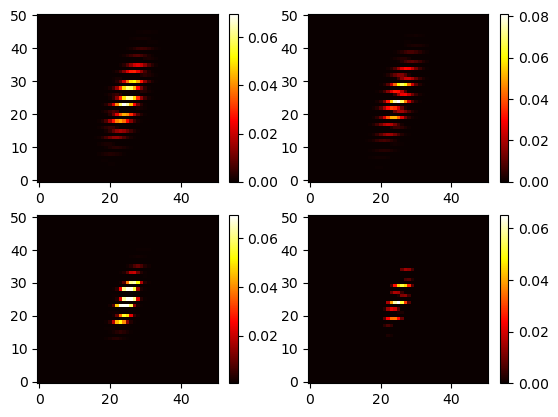

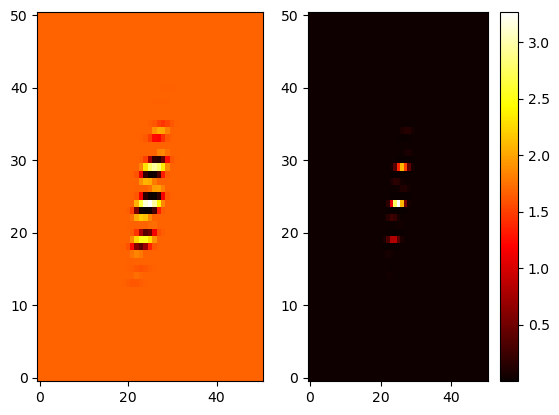

In [290]:
G = hbm.model_of_gabor_filter(mean)[0, ...]

G_inhib = -np.clip(G, -np.inf, 0)
# G_inhib /= G_inhib.max()
G_exc = np.clip(G, 0, np.inf)
# G_exc /= G_exc.max()

fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
img = ax.imshow(G_inhib, cmap="hot", aspect="auto", origin="lower")
plt.colorbar(img)

ax = fig.add_subplot(2, 2, 2)
img = ax.imshow(G_exc, cmap="hot", aspect="auto", origin="lower")
plt.colorbar(img)

from orientation_tuning.HierarchicalBayesInference import softplus, sigmoid, ReLU

input_inhib = sigmoid(G_inhib, G_inhib.max(), G_inhib.max() * 0.1, G_inhib.max() / 2.0)
ax = fig.add_subplot(2, 2, 3)
img = ax.imshow(input_inhib, cmap="hot", aspect="auto", origin="lower")
plt.colorbar(img)

input_exc = ReLU(G_exc, 1.0, 0.0, G_exc.max() * 0.2)
ax = fig.add_subplot(2, 2, 4)
img = ax.imshow(input_exc, cmap="hot", aspect="auto", origin="lower")
plt.colorbar(img)

input = input_exc - input_inhib

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
img = ax.imshow(input, cmap="hot", aspect="auto", origin="lower")

ax = fig.add_subplot(1, 2, 2)
img = ax.imshow(
    softplus(input, 1.0, 0.01, input.max() / 2.0),
    cmap="hot",
    aspect="auto",
    origin="lower",
)
plt.colorbar(img)

print(input.sum())
print(softplus(input.sum(), 1.0, 0.01, input.max() / 2.0))

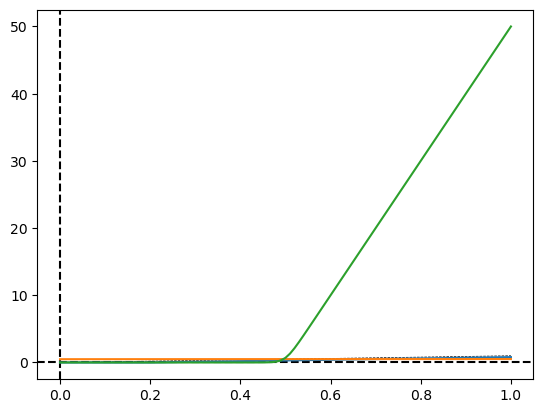

In [ ]:
x = np.linspace(0, 1, 101)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axvline(0, color="k", linestyle="--")
ax.axhline(0, color="k", linestyle="--")
ax.plot(x, x, "k--", linewidth=0.5)

ax.plot(x, ReLU(x, 1, 0.0, 0.2))

ax.plot(x, sigmoid(x, 1, 10.0, 0.5))
ax.plot(x, softplus(x, 1, 0.01, 0.5))

{'amplitude': 0.08309734346744291, 'sigma_x': 5.6144058826340135, 'sigma_y': 10.853751544845021, 'gamma': 0.6961662452912125, 'f': 0.17465228425680063, 'theta': 1.5247908710405915, 'phi_0': 2.440717093165703, 'theta_gauss': 1.2528805823975935, 'nl_alpha': 2.579215279085485}


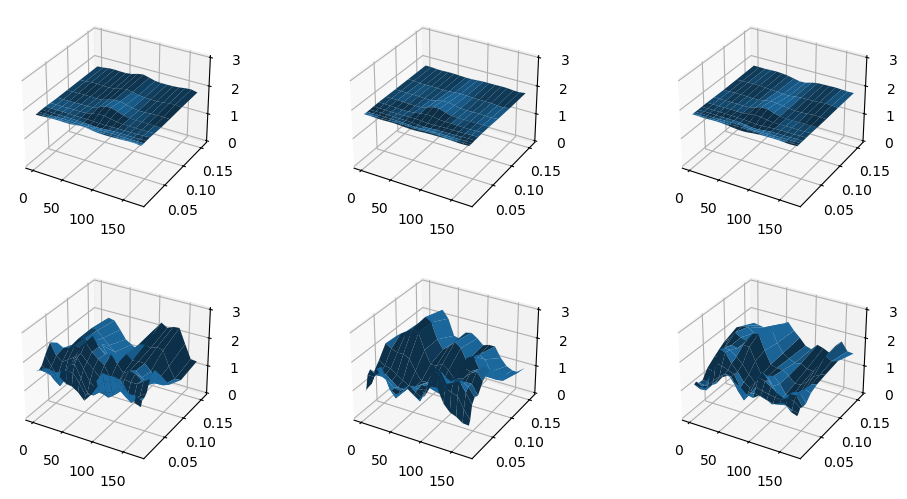

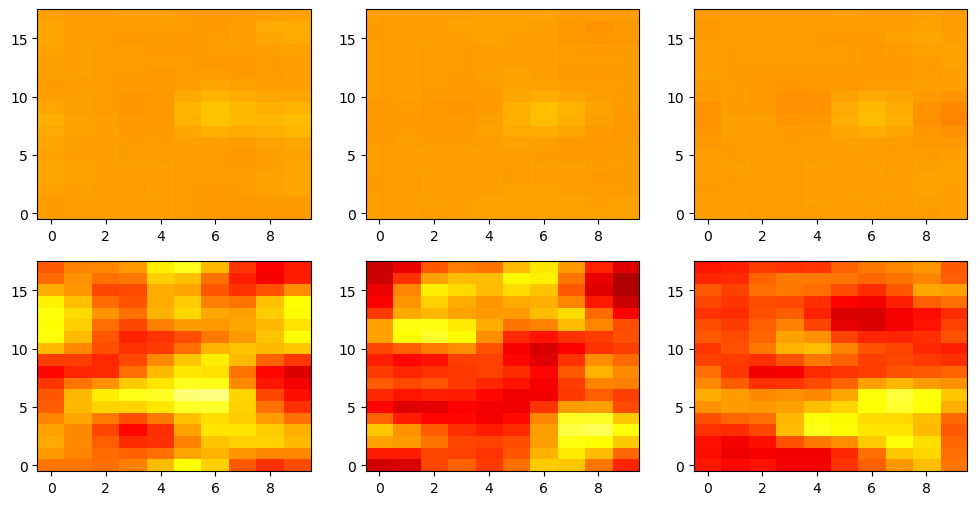

In [ ]:
# %matplotlib widget

# params = {
#     "amplitude": 1.7,
#     "sigma_x": 1.2,
#     "sigma_y": 1.1,
#     "gamma": 2.5,
#     "f": 0.14,
#     "theta": 0.8,
#     "phi_0": 3.16,
#     "theta_gauss": 2.4,
# }

params = {}
print(mean)
for key in params:
    params[key] = np.array([mean[key]])

# G = hbm.model_of_gabor_filter(mean | {"theta": 2.4, "theta_gauss": 0.0})
G = hbm.model_of_gabor_filter(mean)
fmap_model = np.tensordot(G, hbm.gratings, axes=([1, 2], [3, 4]))[0, ...]

X = hbm.grids[1][:, 0, :]
Y = hbm.grids[2][:, 0, :]

fmap_model = gauss_smooth(softplus(fmap_model, 2.6, 0, 0), (0, 1, 1))


fmap = gauss_smooth(firing_maps[..., neuron], (0, 1, 1))


upper_max = 3.0
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(231, projection="3d")
ax1.plot_surface(X, Y, fmap_model[0, ...])
ax2 = fig.add_subplot(232, projection="3d")
ax2.plot_surface(X, Y, fmap_model[1, ...])
ax3 = fig.add_subplot(233, projection="3d")
ax3.plot_surface(X, Y, fmap_model[2, ...])
for axx in [ax1, ax2, ax3]:
    plt.setp(axx, zlim=[0, upper_max])

ax1 = fig.add_subplot(234, projection="3d")
ax1.plot_surface(X, Y, fmap[0, ...])
ax2 = fig.add_subplot(235, projection="3d")
ax2.plot_surface(X, Y, fmap[1, ...])
ax3 = fig.add_subplot(236, projection="3d")
ax3.plot_surface(X, Y, fmap[2, ...])
for axx in [ax1, ax2, ax3]:
    plt.setp(axx, zlim=[0, upper_max])


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(231)
ax1.imshow(
    fmap_model[0, ...],
    cmap="hot",
    aspect="auto",
    origin="lower",
    vmin=0,
    vmax=upper_max,
)
ax2 = fig.add_subplot(232)
ax2.imshow(
    fmap_model[1, ...],
    cmap="hot",
    aspect="auto",
    origin="lower",
    vmin=0,
    vmax=upper_max,
)
ax3 = fig.add_subplot(233)
ax3.imshow(
    fmap_model[2, ...],
    cmap="hot",
    aspect="auto",
    origin="lower",
    vmin=0,
    vmax=upper_max,
)

ax1 = fig.add_subplot(234)
ax1.imshow(
    fmap[0, ...], cmap="hot", aspect="auto", origin="lower", vmin=0, vmax=upper_max
)
ax2 = fig.add_subplot(235)
ax2.imshow(
    fmap[1, ...], cmap="hot", aspect="auto", origin="lower", vmin=0, vmax=upper_max
)
ax3 = fig.add_subplot(236)
ax3.imshow(
    fmap[2, ...], cmap="hot", aspect="auto", origin="lower", vmin=0, vmax=upper_max
)

[140, 114]
get gratings
[[[[-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -7.28807026e-08
    -3.64398469e+01 -1.03899432e+00]
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -2.41291287e+01
    -1.00399915e+01 -4.40396844e+00]
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.58417171e+01
    -3.56030789e+01 -7.43773549e+00]
   ...
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -3.97838271e+00
    -1.01754210e-03 -1.28529583e+01]
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -2.22260654e+01
    -1.54683655e-03 -5.24656777e-04]
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -2.42165409e-04
    -1.05591910e+01 -5.24122117e+00]]

  [[-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -3.62573982e+01
    -7.29726319e+01 -1.49835889e+00]
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -3.51805051e+01
    -4.40967877e+00 -9.70449906e+00]
   [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -6.14737322e+01
    -1.68811014e+01 -1.

array([-18958.56757407, -24833.12571285, -17270.61894739,  -1406.78294776])

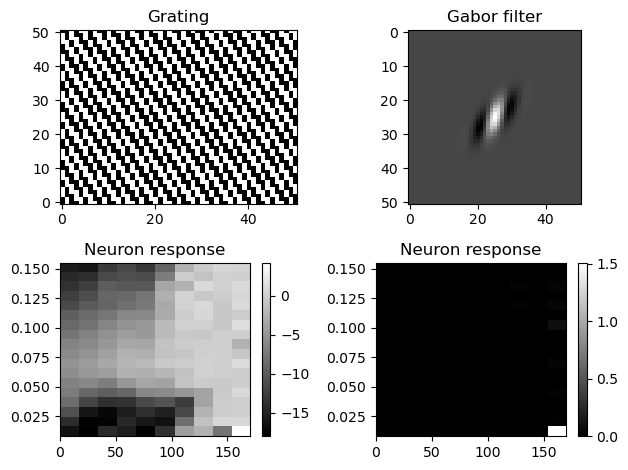

In [302]:
hbm = HierarchicalBayesInference(
    fmap,
    dwelltime[..., neuron],
    (arrays["phases"], arrays["angles"], arrays["cycles"]),
    [140, 114],
)
hbm.set_priors(wrap=["theta", "theta_gauss"])

my_prior_trafo = hbm.set_prior_transform(vectorized=True)
my_logp = hbm.set_logp_func(vectorized=False)

p = np.random.rand(4, hbm.nParams)
p_transformed = my_prior_trafo(p)
p_transformed
params = hbm.from_p_to_params(p_transformed)
logp = my_logp(p_transformed, plot=True)
logp
# params

# hbm.model_of_gabor_filter(params)

phase=120 angle=30 cycle=0.15490000000000004


{'amplitude': array([1.17194212]),
 'sigma_x': array([2.05339944]),
 'sigma_y': array([24.11474784]),
 'gamma': array([5.43132927]),
 'f': array([0.23515964]),
 'theta': array([2.57228526]),
 'phi_0': array([2.06955988]),
 'theta_gauss': array([2.60593079]),
 'nl_alpha': array([0.25963874]),
 'nl_gamma': array([6.52689219]),
 'nl_delta': array([0.73933618])}

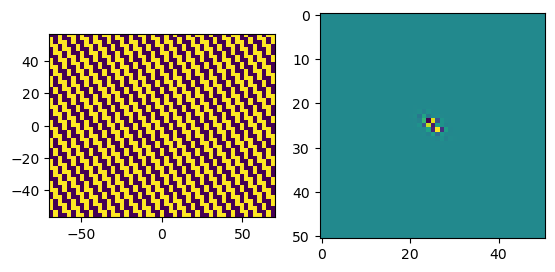

In [50]:
idx_phase, idx_angle, idx_cycle = 0, 3, 9
print(
    f"phase={hbm.measure_points[0][idx_phase]} angle={hbm.measure_points[1][idx_angle]} cycle={hbm.measure_points[2][idx_cycle]}"
)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(
    hbm.gratings[idx_phase, idx_angle, idx_cycle, ...],
    extent=[hbm.X_FoV.min(), hbm.X_FoV.max(), hbm.Y_FoV.min(), hbm.Y_FoV.max()],
    origin="lower",
)

ax = fig.add_subplot(122)
ax.imshow(hbm.model_of_gabor_filter(params))
params

In [63]:
5000 / 80

62.5

In [8]:
import pickle

# with open('inference_result.pkl','wb') as f_open:
# pickle.dump(sampler,f_open)
with open("inference_result.pkl", "rb") as f_open:
    sampler = pickle.load(f_open)

amplitude mean: 2.4047010737930434
sigma_x mean: 1.0430003465429227
sigma_y mean: 1.730688754329086
gamma mean: 0.38228850310336154
f mean: 0.272680959578316
theta mean: 2.5054348904504837
phi_0 mean: 3.1546647628363482
theta_gauss mean: 0.01141337586623926


In [54]:
hist = np.histogramdd(sampler.results.samples[:, [-3, -1]], bins=21, weights=weights)
X, Y = np.meshgrid(*hist[1])

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (17, 9) and arg 2 with shape (21, 21).

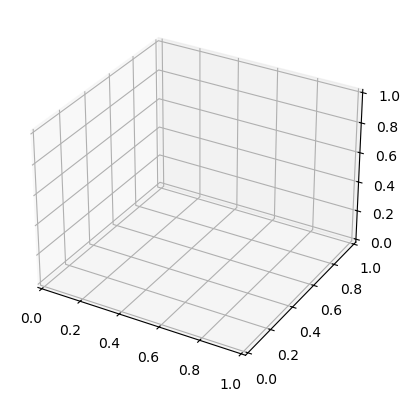

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X[:-1, :-1], Y[:-1, :-1], hist[0])

In [40]:
51**8 * 32 / (1024 * 1024 * 1024)

1363991.0391092598

In [119]:
my_prior_trafo = hbm.set_prior_transform(vectorized=False)
my_logp = hbm.set_logp_func(vectorized=False)

# p = np.random.rand(8)
# p_transformed = my_prior_trafo(p)
p_transformed = list(mean.values())
print(p_transformed)
params = hbm.from_p_to_params(p_transformed)
my_logp(p_transformed)
params

[0.3919226003836449, 1.4610248711443783, 1.2027978652558888, 2.4619901601163017, 0.16515089626909446, 1.5954212280672058, 3.1207012708588193, 1.5712554868213928]


TypeError: list indices must be integers or slices, not tuple

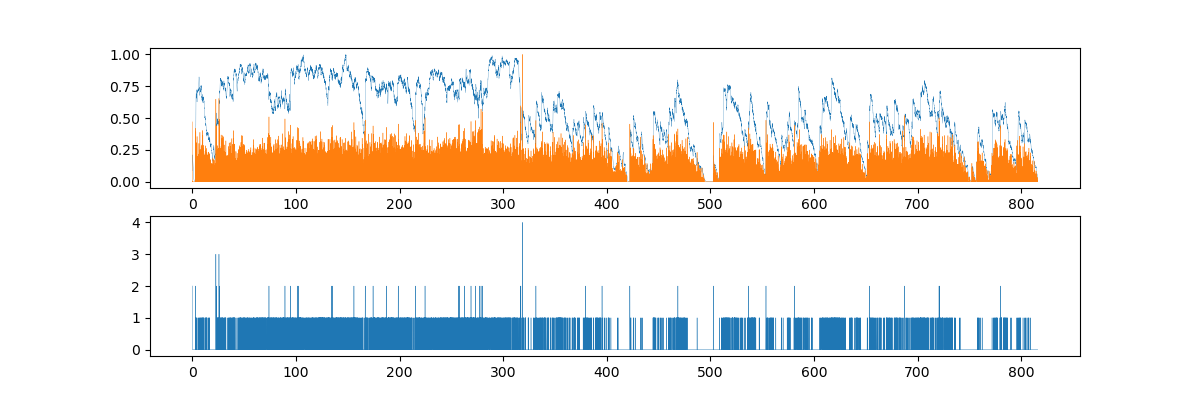

In [19]:
n = 0
# res = get_firingrate(caiman_data["S"][n,:],f=30.05,sd_r=1,Ns_thr=10)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(211)
ax.plot(
    data["frame_times"],
    caiman_data["C"][n, :] / caiman_data["C"][n, :].max(),
    linewidth=0.2,
)
ax.plot(
    data["frame_times"],
    caiman_data["S"][n, :] / caiman_data["S"][n, :].max(),
    linewidth=0.3,
)

ax = fig.add_subplot(212)
ax.plot(data["frame_times"], spikes[n, :], linewidth=0.3)

In [138]:
arrays

{'angles': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170], dtype=uint8),
 'cycles': array([0.0079    , 0.01099588, 0.01530497, 0.02130273, 0.0296509 ,
        0.04127058, 0.05744382, 0.07995507, 0.1112881 , 0.1549    ]),
 'phases': array([120, 240, 360], dtype=uint16)}

In [60]:
def gabor_filter(
    X,
    Y,
    # # Parameters (replace with extracted values from your data)
    A=1.0,  # Amplitude
    sigma_x=1.0,  # Gaussian envelope width along x
    sigma_y=1.0,  # Gaussian envelope width along y
    gamma=1.0,
    f=0.5,  # Spatial frequency
    theta=np.pi / 4,  # Preferred orientation (radians)
    phi_0=np.pi / 3,  # Preferred phase (radians)
    theta_gauss=np.pi / 4.0,
):

    # Rotate coordinates
    x_prime = X * np.cos(theta) + Y * np.sin(theta)
    y_prime = -X * np.sin(theta) + Y * np.cos(theta)

    # print(f"{theta=}, {theta_gauss=}")
    if theta_gauss:
        x_prime_gauss = x_prime * np.cos(theta_gauss) + y_prime * np.sin(theta_gauss)
        y_prime_gauss = -x_prime * np.sin(theta_gauss) + y_prime * np.cos(theta_gauss)
    else:
        x_prime_gauss = x_prime
        y_prime_gauss = y_prime

    # Gabor function
    return (
        A
        * np.exp(
            -(
                x_prime_gauss**2 / (2 * sigma_x**2)
                + gamma**2 * y_prime_gauss**2 / (2 * sigma_y**2)
            )
        )
        * np.cos(2 * np.pi * f * x_prime + phi_0)
    )


def sine_grating(X, Y, theta, f, phi_0, square=False):
    # Rotate coordinates
    x_prime = X * np.cos(theta) + Y * np.sin(theta)

    # Gabor function
    if square:
        return np.sign(np.cos(2 * np.pi * f * x_prime + phi_0))
    else:
        return np.cos(2 * np.pi * f * x_prime + phi_0)

In [70]:
X, Y = np.meshgrid(arrays["cycles"], arrays["angles"])
pos = np.dstack((X, Y))

stimulus_steps = 51
X_stimulus, Y_stimulus = np.meshgrid(
    np.linspace(-100, 100, stimulus_steps), np.linspace(-100, 100, stimulus_steps)
)

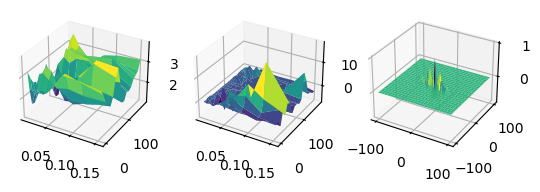

In [73]:
neuron = 14

phase_idx = 2
# fmap = gauss_smooth(firing_maps[..., neuron].max(axis=0), (1, 1), mode="wrap")
fmap = gauss_smooth(firing_maps[phase_idx, ..., neuron], (1, 1), mode="wrap")
fig = plt.figure()
ax_empirical = fig.add_subplot(131, projection="3d")
ax_empirical.plot_surface(X, Y, fmap, cmap="viridis")


ax_model = fig.add_subplot(133, projection="3d")
model = gabor_filter(
    X_stimulus,
    Y_stimulus,
    A=1.0,
    sigma_x=4.0,
    sigma_y=10.0,
    gamma=0.5,
    f=0.12,
    theta=50.0 / 180 * np.pi,
    phi_0=0,
    theta_gauss=20.0 / 180 * np.pi,
)
ax_model.plot_surface(X_stimulus, Y_stimulus, model, cmap="viridis")

ax_model_response = fig.add_subplot(132, projection="3d")

fmap_model_at_phase = np.zeros((3, steps["angles"], steps["cycles"]))
for prod in itertools.product(enumerate(arrays["angles"]), enumerate(arrays["cycles"])):

    idx, elems = zip(*prod)
    theta, f = elems

    response_at_phi = np.zeros(steps["phases"])
    for i, phi_ in enumerate(arrays["phases"]):
        grating_ = sine_grating(
            X_stimulus,
            Y_stimulus,
            theta * np.pi / 180,
            f,
            phi_ * np.pi / 180,
            square=True,
        )
        response_at_phi[i] = (model * grating_).sum()

    for i in range(3):
        # print(i,i * (steps["phi_0"] // 3), arrays['phi_0'][i * (steps["phi_0"] // 3)])
        fmap_model_at_phase[i, idx[0], idx[1]] = response_at_phi[
            i * (steps["phases"] // 3)
        ]

ax_model_response.plot_surface(
    X, Y, fmap_model_at_phase[phase_idx, ...], cmap="viridis"
)

In [187]:
def probability_of_spike_observation(fmap, dwelltime, fmap_model):
    ## get probability to observe N spikes (amplitude) within dwelltime for each bin in each trial

    log_fmap_factorial = np.log(sp_factorial(fmap))
    # print(log_fmap_factorial)
    logp = fmap * np.log(fmap_model * dwelltime) - log_fmap_factorial - fmap * dwelltime

    # logp[np.logical_and(fmap == 0, fmap == 0)] = 0
    logp[np.isnan(logp)] = -1000.0
    # logp[np.isinf(logp)] = -100.0  # np.finfo(logp.dtype).min
    return logp

In [192]:
fmap = gauss_smooth(firing_maps[..., neuron], (0, 1, 1), mode="wrap")
logp = probability_of_spike_observation(
    fmap, dwelltime[..., neuron], fmap_model_at_phase
)
## why positive?
## get proper dwelltime
## should transfer S to spikes first? (thresholding)

logp.sum()

-381507.76984926825

In [81]:
stimulus_steps = 101
X_stimulus, Y_stimulus = np.meshgrid(
    np.linspace(-100, 100, stimulus_steps), np.linspace(-100, 100, stimulus_steps)
)

G = gabor_filter(
    X_stimulus,
    Y_stimulus,
    A=1.0,
    sigma_x=4.0,
    sigma_y=10.0,
    gamma=0.5,
    f=0.12,
    theta=50.0 / 180 * np.pi,
    phi_0=0,
    theta_gauss=20.0 / 180 * np.pi,
)

gratings = np.zeros(
    (steps["phases"], steps["angles"], steps["cycles"], stimulus_steps, stimulus_steps)
)
responses = np.zeros((steps["phases"], steps["angles"], steps["cycles"]))
for prod in itertools.product(
    enumerate(arrays["phases"]),
    enumerate(arrays["angles"]),
    enumerate(arrays["cycles"]),
):
    idx, elems = zip(*prod)
    phi_0, theta, f = elems

    gratings[*idx, ...] = sine_grating(
        X_stimulus, Y_stimulus, theta * np.pi / 180, f, phi_0 * np.pi / 180, square=True
    )

In [246]:
phase_grid, angle_grid, cycle_grid = np.meshgrid(
    arrays["phases"], arrays["angles"], arrays["cycles"]
)
cycle_grid[:, 0, :].shape

(18, 10)

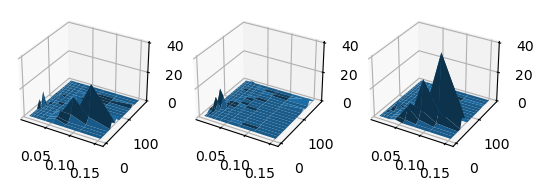

In [69]:
def get_responses(
    gratings,
    X_stimulus,
    Y_stimulus,
    A=1.0,
    sigma_x=4.0,
    sigma_y=10.0,
    gamma=0.5,
    f=0.12,
    theta=50.0 / 180 * np.pi,
    phi_0=70.0,
    theta_gauss=20.0 / 180 * np.pi,
):

    G = gabor_filter(
        X_stimulus,
        Y_stimulus,
        A=A,
        sigma_x=sigma_x,
        sigma_y=sigma_y,
        gamma=gamma,
        f=f,
        theta=theta,
        phi_0=phi_0,
        theta_gauss=theta_gauss,
    )
    responses = (G * gratings).sum(axis=(-2, -1))
    return responses


responses = get_responses(gratings, X_stimulus, Y_stimulus)

fig = plt.figure()
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot_surface(X, Y, np.maximum(1, responses[0, ...]))
ax2 = fig.add_subplot(132, projection="3d")
ax2.plot_surface(X, Y, np.maximum(1, responses[1, ...]))
ax3 = fig.add_subplot(133, projection="3d")
ax3.plot_surface(X, Y, np.maximum(1, responses[2, ...]))

for axx in [ax1, ax2, ax3]:
    plt.setp(axx, zlim=[0, 40])
# gratings.shape

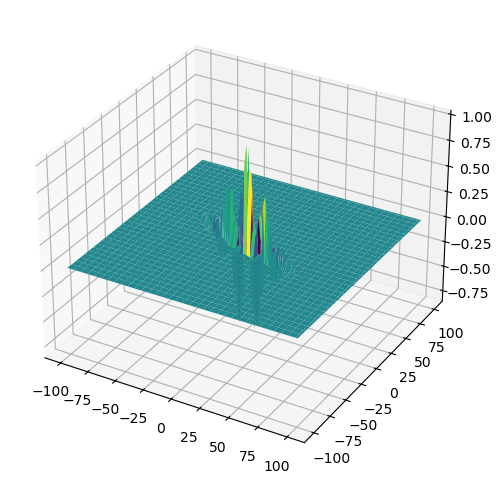

In [82]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111, projection="3d")
ax1.plot_surface(X_stimulus, Y_stimulus, G, cmap="viridis")
# ax2 = fig.add_subplot(132, projection="3d")
# ax2.plot_surface(X, Y, np.maximum(1, responses[1, ...]))
# ax3 = fig.add_subplot(133, projection="3d")
# ax3.plot_surface(X, Y, np.maximum(1, responses[2, ...]))

In [75]:
%timeit (G * gratings).sum(axis=(-2,-1))

1.21 ms ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [76]:
%timeit np.tensordot(G,gratings,axes=([0,1],[3,4]))

205 µs ± 3.55 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [51]:
def covariance_matrix(standard_deviation, theta):
    # Covariance matrix
    # print(theta)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    Lambda = np.diag(standard_deviation**2)
    # print(f"{R=}, {Lambda=}")
    return R @ Lambda @ R.T


# Gaussian function
def multivariate_gaussian(pos, mu, Sigma):
    # n = mu.shape[0]
    print(Sigma)
    # print(pos.shape,mu.shape)
    diff = pos - mu
    # print(diff)
    inv_Sigma = np.linalg.inv(Sigma)
    det_Sigma = np.linalg.det(Sigma)
    # print(inv_Sigma, det_Sigma)
    norm_const = 1.0 / (2 * np.pi * np.sqrt(det_Sigma))
    result = np.einsum("...i,ij,...j->...", diff, inv_Sigma, diff)
    return norm_const * np.exp(-0.5 * result)


def orientation_model(pos, A, mean_x, mean_y, sigma_x, sigma_y, theta):
	## adjust all values for radians
	theta *= np.pi / 180.0
	mean_x *= np.pi / 180.0
	sigma_x *= np.pi / 180.0
	pos[...,0] *= np.pi / 180.0

	mu = np.array([mean_x, mean_y])
	standard_deviation = np.array([sigma_x, sigma_y])

	Sigma = covariance_matrix(standard_deviation, theta)	Z = A * multivariate_gaussian(pos, mu, Sigma)

	return Z

[[0.01648087 0.01398087]
 [0.01398087 0.01648087]]


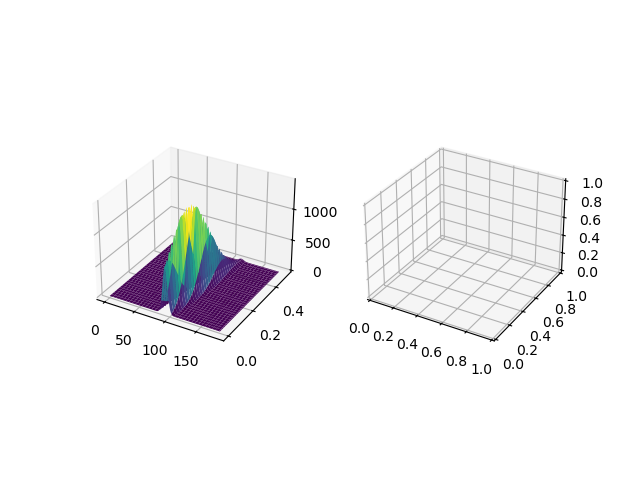

In [76]:
n = 8
# theta = data['angle']
# theta = np.linspace(0,np.pi,21)
# cycles = data['CPD']
theta = np.linspace(0, 180.0, 101)
cycles = np.linspace(0, 0.5, 101)
X, Y = np.meshgrid(theta, cycles)
pos = np.dstack((X, Y))


fig = plt.figure()
ax = fig.add_subplot(121, projection="3d")
model = orientation_model(pos, 80.0, 100.0, 0.15, 10.0, 0.05, 45.0)

ax.plot_surface(X, Y, model, cmap="viridis")

ax = fig.add_subplot(122, projection="3d")
# ax.plot_surface(X, Y, gauss_smooth(firing_maps[2,...,n],(1,1)).T, cmap='viridis')

# logp = probability_of_spike_observation(firing_maps[2,...,n].T, dwelltime[2,...,n].T, model)
# logp

# for some reason, ellipse is not properly created (inverse not well defined?)
# anyway, maybe rather fit gabor filter to data?
# 	however, requires to calculate response for each combination theta,cycle (including gratings, ...)
# 	define function to get that - how to make it not that costly? precalculate all gratings? vectorized multiplication?

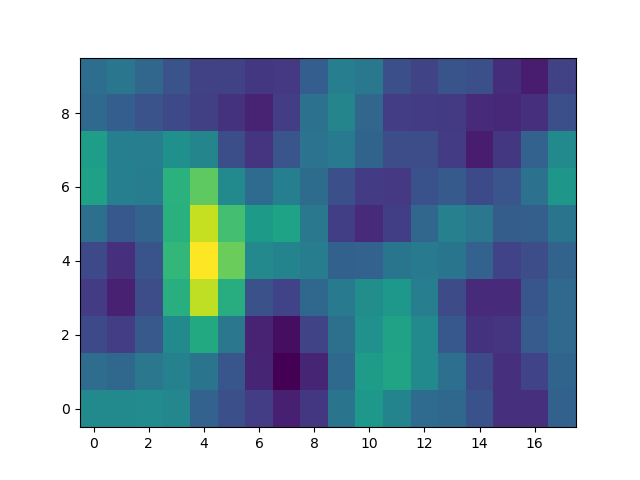

In [72]:
n = 8

fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(
    gauss_smooth(firing_maps[2, ..., n], (1, 1)).T,
    origin="lower",
    aspect="auto",
    cmap="viridis",
)